Turns out the correspondence between cleaned ILI data spatial joined with pipeline segments, and the pipeline segments in EC_Risk_LOF table in Mariner isn't great.

Re-did the process by spatializing the `EC_Risk_LOF` as events in ArcMAP, and then spatial joining these events against the cleaned ILI data spatial-joined with pipeline segments. Hopefully there's better correspondence of the pipe segments.

In [1]:
# Plotting and math imports
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(style="darkgrid")

import pandas as pd

from datetime import datetime
from typing import List, Optional, Dict

# Load the spatially-joined, spatially-joined data saved in csv

In [7]:
ILI_2022_joined_pipeline_joins_EC_LOF_filename = r"C:\Users\A1YU\OneDrive - PGE\Documents\code\ModelPerformance\processed_data\cleaned_ILI_2022_joined_pipes_joins_EC_Risk_LOF_Events.csv"
master_dataset = pd.read_csv(ILI_2022_joined_pipeline_joins_EC_LOF_filename, low_memory=False)

In [8]:
master_dataset.columns.values

array(['OBJECTID_12', 'FID_1', 'OBJECTID_1', 'FID_1_1', 'Vendor',
       'Source', 'Route', 'Route_NoPr', 'MP1', 'MP2', 'Year',
       'ILI_Projec', 'ML_Survey', 'Alignment', 'Joint___US', 'ILI_Survey',
       'Joint_Leng', 'From_U_S_G', 'To_D_S_GW', 'Identifica', 'Comment',
       'Tool_Speed', 'WT__in_', 'SMYS__PSI_', 'MAOP__PSI_', 'OD__in_',
       'Longseam_V', 'Seam_Pos_', 'Depth____', 'Depth___wi', 'OD_Reducti',
       'Length__in', 'Width__in_', 'O_clock', 'Internal', 'Bend_Radiu',
       'Bend_Angle', 'Bend_Direc', 'POF_Catego', 'Associated',
       'Anomaly_ID', 'Estimated', 'Pf_MAOP', 'Pf___with', 'Pf__MAOP',
       'TotalBend', 'Bend___Ver', 'Bend___Hor', 'Internal_D',
       'External_D', 'Easting', 'Northing', 'Latitude', 'Longitude',
       'Elevation', 'U_S_Refere', 'Dist__To_U', 'D_S_Refere',
       'Dist__To_D', 'ILI_Vendor', 'PG_E_Stati', 'OBJECTID', 'Id',
       'EffectiveS', 'PipeManufa', 'PipeOutsid', 'PipeWallTh', 'SMYS',
       'PipeGradeD', 'PipeMateri', 'PipeRe

The field names gets screwed up/cut off during the spatial-join and writing to csv process (might need to do all this in ArcPy..). Let's rename them to actual names.

In [9]:
# First change the fields from ILI that we want
# FP_fields = ['Estimated Failure Pressure (Pf) ', 'Pf/MAOP', 'Pf* (with tool tolerances)', 'Pf*/MAOP']

master_dataset.rename(
    columns={
        "Estimated": "Estimated Failure Pressure (Pf)",
        "Pf_MAOP": "Pf/MAOP",
        "Pf___with": "Pf* (with tool tolerances)",
        "Pf__MAOP": "Pf*/MAOP",
    },
    inplace=True
)
FP_fields = ['Estimated Failure Pressure (Pf)', 'Pf/MAOP', 'Pf* (with tool tolerances)', 'Pf*/MAOP']

In [10]:
# Now change the EC_LOF_Risk values

calculated_risk_fields =  ['EC_LOF_Leak', 'EC_LOF_Rupture']
master_dataset.rename(
    columns={
        "EC_LOF_Rup": "EC_LOF_Rupture",
        "EC_LOF_Lea": "EC_LOF_Leak",
    },
    inplace=True
)

In [19]:
# Also get the stationing number, so we are not simply comparing individual anomaly to pipe values
location_fields = ["route", "beginstationseriesid", "beginstationnum", "endstationseriesid", "endstationnum"]
master_dataset.rename(
    columns={
        "Route": "route",
        "BeginStati": "beginstationseriesid",
        "BeginSta_1": "beginstationnum",
        "EndStation": "endstationseriesid",
        "EndStati_1": "endstationnum",
    },
    inplace=True
)

In [23]:
# Get the data frame with just these fields
relevant_fields = FP_fields + calculated_risk_fields + location_fields
performance_df = master_dataset[relevant_fields]

In [24]:
performance_df.head()

,Estimated Failure Pressure (Pf),Pf/MAOP,Pf* (with tool tolerances),Pf*/MAOP,EC_LOF_Leak,EC_LOF_Rupture,route,beginstationseriesid,beginstationnum,endstationseriesid,endstationnum
0,NaN,NaN,NaN,NaN,9.166055e-08,0.0,DFM-1209-01,39887,29018.0,39887,29098.0
1,2346.0,3.61,2300.0,3.54,9.166055e-08,0.0,DFM-1209-01,39887,39389.5,39887,39650.5
2,NaN,NaN,NaN,NaN,9.166055e-08,0.0,DFM-1209-01,39887,39389.5,39887,39650.5
3,NaN,NaN,NaN,NaN,9.166055e-08,0.0,DFM-1209-01,39887,39389.5,39887,39650.5
4,NaN,NaN,NaN,NaN,9.166055e-08,0.0,DFM-1209-01,39887,39389.5,39887,39650.5


I think when all the failure pressure values are NULL, they get imported into ArcMAP as 0. So need to change them to `NaN`.

The risk values can actually be 0, judging by the mariner DB output.

In [25]:
master_dataset[FP_fields] = master_dataset[FP_fields].replace(0, np.nan)

In [26]:
performance_df.head()

,Estimated Failure Pressure (Pf),Pf/MAOP,Pf* (with tool tolerances),Pf*/MAOP,EC_LOF_Leak,EC_LOF_Rupture,route,beginstationseriesid,beginstationnum,endstationseriesid,endstationnum
0,NaN,NaN,NaN,NaN,9.166055e-08,0.0,DFM-1209-01,39887,29018.0,39887,29098.0
1,2346.0,3.61,2300.0,3.54,9.166055e-08,0.0,DFM-1209-01,39887,39389.5,39887,39650.5
2,NaN,NaN,NaN,NaN,9.166055e-08,0.0,DFM-1209-01,39887,39389.5,39887,39650.5
3,NaN,NaN,NaN,NaN,9.166055e-08,0.0,DFM-1209-01,39887,39389.5,39887,39650.5
4,NaN,NaN,NaN,NaN,9.166055e-08,0.0,DFM-1209-01,39887,39389.5,39887,39650.5


Not sure how to aggregate over the staioning yet... but let's plot all the non-NAN Pf numbers against the EC values.

In [37]:
filtered_df = performance_df[
    performance_df[FP_fields].notnull().all(1)
]

In [38]:
filtered_df.head()

,Estimated Failure Pressure (Pf),Pf/MAOP,Pf* (with tool tolerances),Pf*/MAOP,EC_LOF_Leak,EC_LOF_Rupture,route,beginstationseriesid,beginstationnum,endstationseriesid,endstationnum
1,2346.0,3.61,2300.0,3.54,9.166055e-08,0.0,DFM-1209-01,39887,39389.5,39887,39650.5
70,2935.0,4.52,2923.0,4.50,1.154881e-07,0.0,DFM-1209-01,39887,2632.0,39887,3602.0
71,2911.0,4.48,2882.0,4.43,1.154881e-07,0.0,DFM-1209-01,39887,2632.0,39887,3602.0
72,2932.0,4.51,2912.0,4.48,1.154881e-07,0.0,DFM-1209-01,39887,2632.0,39887,3602.0
98,2419.0,3.72,2403.0,3.70,9.166055e-08,0.0,DFM-1209-01,39887,45977.9,39887,47393.6


Text(0.5, 0.98, 'Failure pressure vs. Leak LOF')

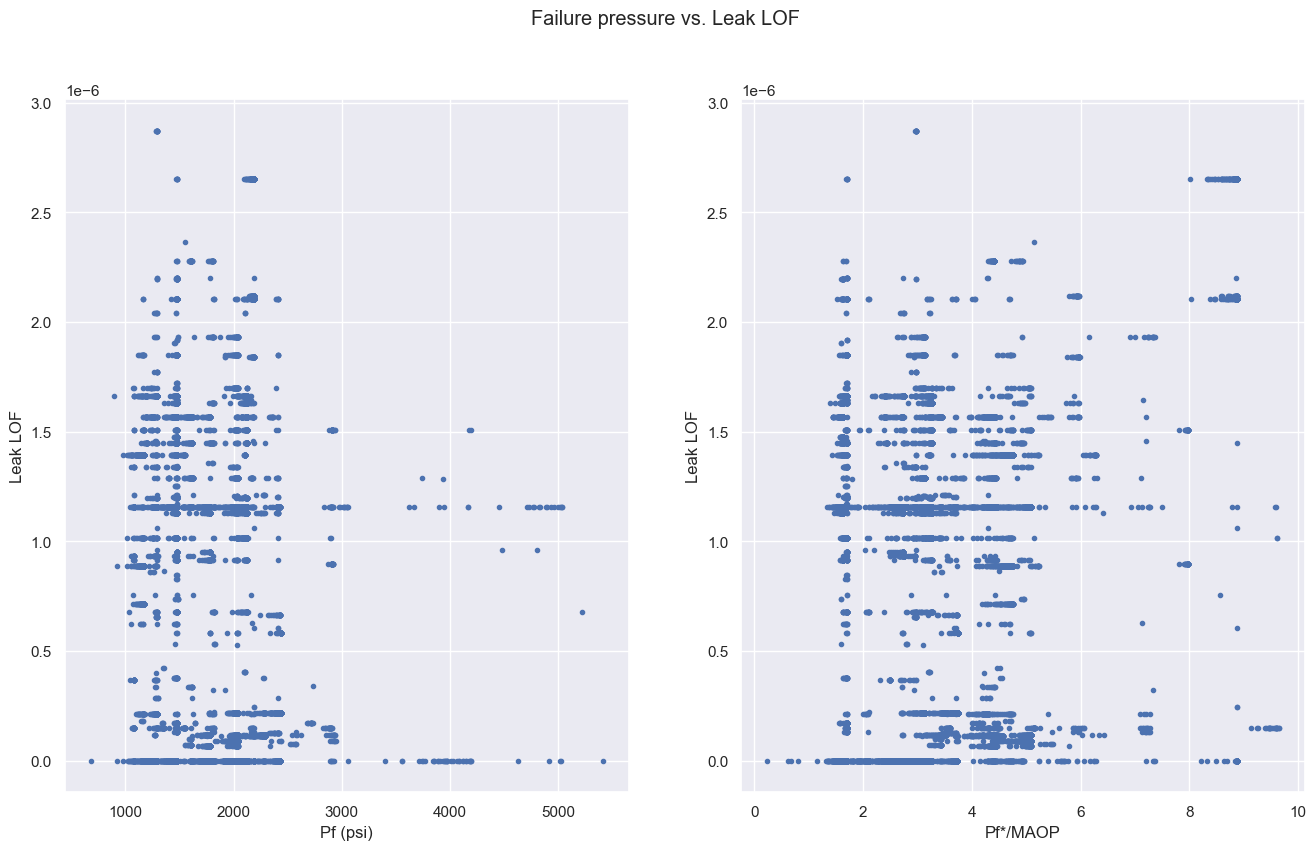

In [43]:
plt.figure(figsize=(16, 9))
plt.subplot(1, 2, 1)
plt.plot(
    filtered_df["Estimated Failure Pressure (Pf)"],
    filtered_df["EC_LOF_Leak"],
    "."
)
plt.xlabel("Pf (psi)")
plt.ylabel("Leak LOF")

plt.subplot(1, 2, 2)
plt.plot(
    filtered_df["Pf*/MAOP"],
    filtered_df["EC_LOF_Leak"],
    "."
)
plt.xlabel("Pf*/MAOP")
plt.ylabel("Leak LOF")
plt.suptitle("Failure pressure vs. Leak LOF")

Text(0.5, 0.98, 'Failure pressure vs. Rupture LOF')

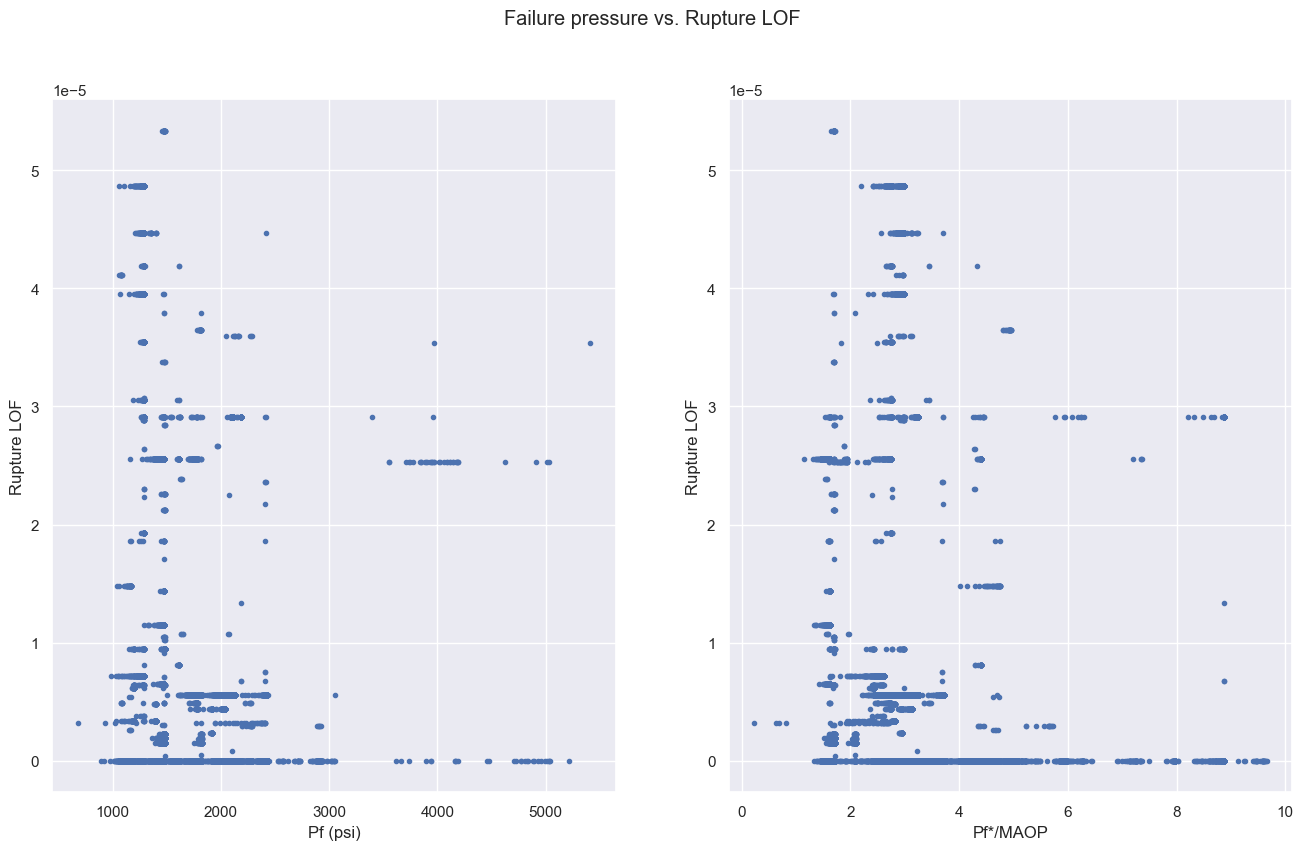

In [44]:
plt.figure(figsize=(16, 9))
plt.subplot(1, 2, 1)
plt.plot(
    filtered_df["Estimated Failure Pressure (Pf)"],
    filtered_df["EC_LOF_Rupture"],
    "."
)
plt.xlabel("Pf (psi)")
plt.ylabel("Rupture LOF")

plt.subplot(1, 2, 2)
plt.plot(
    filtered_df["Pf*/MAOP"],
    filtered_df["EC_LOF_Rupture"],
    "."
)
plt.xlabel("Pf*/MAOP")
plt.ylabel("Rupture LOF")
plt.suptitle("Failure pressure vs. Rupture LOF")

In [1]:
# use log scale for the LOF scale

In [2]:
# aggregate anomalies' Pf per dynamic segment